In [241]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from tqdm import tqdm
from nltk.corpus import stopwords
stopwordEn = stopwords.words('english')
import pickle
import time

In [242]:
# file 11 contains 28 Mar & 29 Mar
with open('df_0328_tweets.pickle', 'rb') as handle:
    df_0328_tweets = pickle.load(handle)

with open('df_0329_tweets.pickle', 'rb') as handle:
    df_0329_tweets = pickle.load(handle)
len(df_0328_tweets),len(df_0329_tweets)

(625523, 333494)

# Combine Data

In [243]:
df_comb = pd.concat([df_0328_tweets,df_0329_tweets])
df_comb.head()

created_at  \
0  Sat Mar 28 08:18:01 +0000 2020   
1  Sat Mar 28 08:18:01 +0000 2020   
2  Sat Mar 28 08:18:01 +0000 2020   
3  Sat Mar 28 08:18:01 +0000 2020   
4  Sat Mar 28 08:18:01 +0000 2020   

                                           full_text  \
0  RT @Being_Humor: When India was fighting Coron...   
1  RT @holasaraa: At this point if I see another ...   
2  RT @IndiaToday: #CoronavirusPandemic | IMF chi...   
3  RT @Kanagalogy: Where is India's Health Minist...   
4  Anger at Belgium’s dysfunctional political sys...   

                                        re_full_text  
0  When India was fighting Corona \n\n.@ndtv was ...  
1  At this point if I see another jogger claiming...  
2  #CoronavirusPandemic | IMF chief said global e...  
3  Where is India's Health Minister  @drharshvard...  
4

In [244]:
df_comb.shape

(959017, 3)

In [245]:
len(df_comb.full_text.unique()),len(df_comb.re_full_text.unique())

(354505, 66096)

In [246]:
full_texts = df_comb[df_comb['re_full_text']!='']['re_full_text'] # 转发的原文
len(full_texts),len(full_texts.unique()) #转发的原推数

(669409, 66095)

In [247]:
full_texts_orig = df_comb[df_comb['re_full_text']=='']['full_text'] #原创的且未在这个时间段被转发过
len(full_texts_orig),len(full_texts_orig.unique()) #大部分原创推特都没有重复

(289608, 287089)

In [248]:
full_texts_all = pd.concat([full_texts,full_texts_orig])
len(full_texts_all),len(full_texts_all.unique())

(959017, 310420)

# Multiprocessing

In [249]:
import multiprocessing as mp
import numpy as np
print('CPU numbers:',mp.cpu_count())
def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
#     print(kwargs)
    workers = kwargs.pop('workers')
    pool = mp.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))
#apply_by_multiprocessing(fullset['Text'], process_text, workers=cores)

CPU numbers: 32


# Pos tagging

In [250]:
def getPos(s):
    return [i[1] for i in nltk.pos_tag(word_tokenize(s))]

In [251]:
# retweeted tweets
df = pd.DataFrame(pd.Series(full_texts).value_counts())
df = df.rename(columns={'re_full_text':'count'})
df['text'] = df.index
df.index = range(len(df))
s_py = time.time()
df['pos'] = apply_by_multiprocessing(df['text'], getPos, workers=32)
print("programme:",time.time()-s_py)
df.head()

programme: 15.160565853118896


count                                               text  \
0  33264  Due to Corona, we officially have three days o...   
1  21348  corona virus got people being horny, depressed...   
2  20953  It’s time we all do our bit to help defeat #CO...   
3  18301  World BEST medevac for COVID patient.\nGermany...   
4  15952  i’ve decided i’m pushing my birthday back to j...   

                                                 pos  
0  [JJ, TO, NNP, ,, PRP, RB, VBP, CD, NNS, IN, DT...  
1  [NN, NN, VBD, NNS, VBG, NN, ,, VBD, ,, JJ, CC,...  
2  [PRP, VBZ, JJ, NN, PRP, DT, VBP, PRP$, NN, TO,...  
3  [NNP, NNP, NN, IN, NNP, NN, ., NNP, VBZ, PRP$,...  
4  [NN, VBP, NN, VBD, JJ, NNP, NN, VBG, PRP$, NN,...

In [252]:
# original tweets
df_orig = pd.DataFrame(pd.Series(full_texts_orig).value_counts())
df_orig = df_orig.rename(columns={'full_text':'counts'})
df_orig['text'] = df_orig.index
df_orig.index = range(len(df_orig))
df_orig['pos'] = apply_by_multiprocessing(df_orig['text'], getPos, workers=32)
df_orig.head()

counts                                               text  \
0     144  During this Corona crisis we thank the hero ph...   
1      36  @nsitharaman ,@WHO ,@PMOIndia ,@narendramodi ,...   
2      31  #MannKiBaat\nPM Modi interacts with citizens w...   
3      30                  @iVergex @musicbyanz CORONA SUCKS   
4      21  @KSIOlajidebt Look at my wrist corona, my neck...   

                                                 pos  
0  [IN, DT, NNP, NN, PRP, VBD, DT, NN, NNS, IN, V...  
1  [JJ, NN, ,, NN, NNP, ,, NNP, NNP, ,, NNP, NN, ...  
2  [#, NNP, NNP, NNP, VBZ, IN, NNS, WP, VBP, VBN,...  
3                        [JJ, NN, NNP, NN, NNP, NNP]  
4  [JJ, NNP, NNP, IN, PRP$, NN, NN, ,, PRP$, NN, ...

In [253]:
df_total = pd.concat([df,df_orig])
df.shape,df_orig.shape,df_total.shape

((66095, 3), (287089, 3), (353184, 4))

In [137]:
# Graph-based FP mining edges即为共现序列
def buildEdges(df, k=2, minS=10, raw=False, unique=False, pos=True):  
# l为输入的序列集合， k是序列中行为的个数 默认为2，minS是最小支持度 默认为10, 若raw为真返回原始全部dict数据
  edges = {}
  for r in range(len(df)):
    s = df.pos[r] if pos else word_tokenize(df.text[r])
    s=s[:]
    s.insert(0,'s') # start notation
    for i in range(len(s)):
      if i+ k <= len(s):
        edge = '-'.join(s[i:i+k]) 
        c = df.counts[r] if unique==False else 1
        if edge in edges:
          edges[edge] += c
        else:
          edges[edge] = c
  
  df_edges = pd.DataFrame(edges,index=['Support']).T.sort_values(by=['Support'],ascending=False)
  stat = {'TotalCombinations':len(df_edges),'min':df_edges['Support'].min(),
          'median':df_edges['Support'].median(),'mean':df_edges['Support'].mean(),
          'max':df_edges['Support'].max()
         }
  return df_edges[df_edges['Support']>minS],pd.DataFrame([stat]) if raw==False else edges
# 输出为tuple, [0]项为dataframe结果，[1]为全部组合的统计数据

# HashTags

In [254]:
all_hashtags = [] 
for text in tqdm(full_texts):
    tags = re.findall('#(.*?) ',text)
    all_hashtags.extend(tags)

100%|██████████| 669409/669409 [00:01<00:00, 339629.25it/s]


In [255]:
all_hashtags_orig = [] 
for text in tqdm(full_texts_orig):
    tags = re.findall('#(.*?) ',text)
    all_hashtags_orig.extend(tags)

100%|██████████| 289608/289608 [00:00<00:00, 351027.81it/s]


In [256]:
all_hashtags_total = pd.concat([pd.Series(all_hashtags),pd.Series(all_hashtags_orig)])
len(all_hashtags),len(all_hashtags_orig),len(all_hashtags_total)

(377860, 156963, 534823)

In [257]:
len(pd.Series(all_hashtags).unique()),len(pd.Series(all_hashtags_orig).unique()),len(pd.Series(all_hashtags_total).unique())

(16689, 35990, 40905)

In [258]:
pd.Series(all_hashtags).value_counts()

Corona               47532
IndiaFightsCorona    25350
COVID19.             22198
StayHomeIndia        21760
COVID19               9685
                     ...  
running                  1
planeta                  1
ketocoach                1
Libyan                   1
asmrrelax                1
Length: 16689, dtype: int64

In [259]:
pd.Series(all_hashtags_orig).value_counts()

Corona                    7889
corona                    7745
COVID19                   4247
coronavirus               3931
CoronaUpdate              2752
                          ... 
stopmigrants                 1
DontTouchThis                1
fernetbranca                 1
Naughty                      1
digitalmarketingtrends       1
Length: 35990, dtype: int64

In [260]:
hashtags_dict = nltk.FreqDist(all_hashtags)
hashtags_orig_dict = nltk.FreqDist(all_hashtags_orig)
hashtags_total_dict = nltk.FreqDist(all_hashtags_total)

len(hashtags_dict),len(hashtags_orig_dict),len(hashtags_total_dict)

(16689, 35990, 40905)

# Word Frequency

In [261]:
#multiprocessing method takes 30 seconds
all_words = []
s_py = time.time()
for i in apply_by_multiprocessing(full_texts, processText, workers=32):
    all_words.extend(i)
print("programme:",time.time()-s_py)

programme: 39.59656476974487


In [262]:
all_words_orig = []
def processText(text):
    tokens = word_tokenize(text)
    return [i for i in tokens if i not in stopwordEn and i.isalpha()]
s_py = time.time()
for i in apply_by_multiprocessing(full_texts_orig, processText, workers=32):
    all_words_orig.extend(i)
print("programme:",time.time()-s_py)

programme: 15.534208536148071


In [263]:
all_words_total = pd.concat([pd.Series(all_words),pd.Series(all_words_orig)])
len(all_words),len(all_words_orig),len(all_words_total)

(11800675, 4104064, 15904739)

In [264]:
words_dict = nltk.FreqDist(all_words)
words_orig_dict = nltk.FreqDist(all_words_orig)
words_total_dict =  nltk.FreqDist(all_words_total)
len(words_dict),len(words_orig_dict),len(words_total_dict)

(92112, 218554, 232962)

# Word cloud

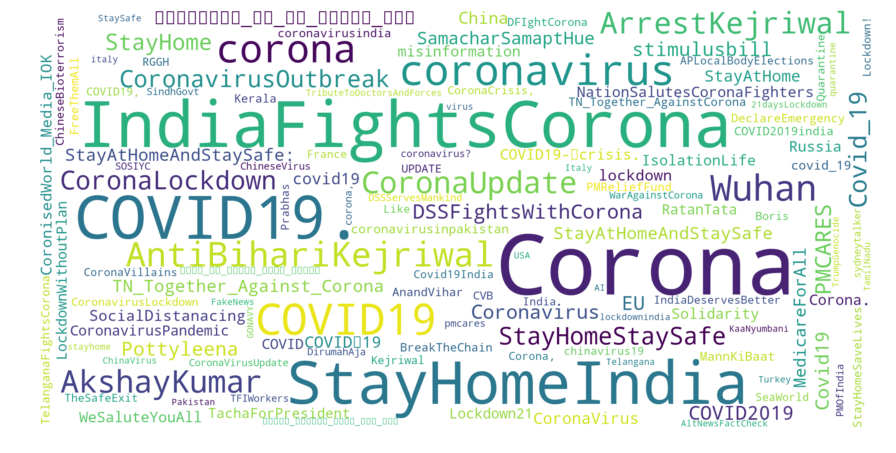

In [265]:
# tags cloud (retweeted tweets)
# https://www.datacamp.com/community/tutorials/wordcloud-python
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
# % matplotlib inline

wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=20, max_words=1000, background_color="white").generate_from_frequencies(hashtags_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [266]:
hashtags_dict.most_common(30)

[('Corona', 47532),
 ('IndiaFightsCorona', 25350),
 ('COVID19.', 22198),
 ('StayHomeIndia', 21760),
 ('COVID19', 9685),
 ('coronavirus', 9039),
 ('corona', 7858),
 ('Wuhan', 6578),
 ('AntiBihariKejriwal', 5909),
 ('AkshayKumar', 4958),
 ('CoronaUpdate', 4728),
 ('ArrestKejriwal', 4619),
 ('CoronaLockdown', 3262),
 ('Covid_19', 2940),
 ('StayHomeStaySafe', 2820),
 ('CoronavirusOutbreak', 2684),
 ('StayHome', 2426),
 ('PMCARES', 2296),
 ('DSSFightsWithCorona', 1931),
 ('Coronavirus', 1886),
 ('stimulusbill', 1768),
 ('COVID2019', 1761),
 ('EU', 1755),
 ('Pottyleena', 1730),
 ('Covid19', 1684),
 ('संस्कृति_की_ओर_बढ़ते_कदम', 1519),
 ('SamacharSamaptHue', 1455),
 ('StayAtHomeAndStaySafe:', 1381),
 ('TN_Together_Against_Corona', 1381),
 ('StayAtHomeAndStaySafe', 1351)]

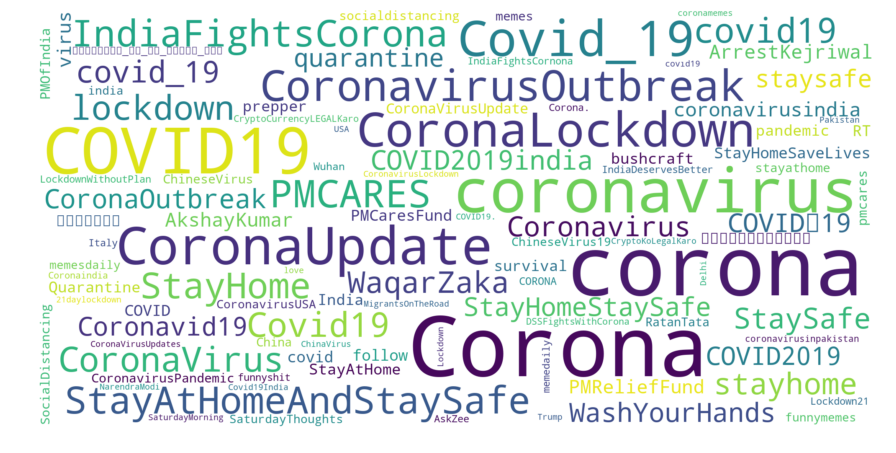

In [267]:
# tags cloud (original tweets)
# https://www.datacamp.com/community/tutorials/wordcloud-python
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=20, max_words=1000, background_color="white").generate_from_frequencies(hashtags_orig_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [268]:
hashtags_orig_dict.most_common(30)

[('Corona', 7889),
 ('corona', 7745),
 ('COVID19', 4247),
 ('coronavirus', 3931),
 ('CoronaUpdate', 2752),
 ('Covid_19', 2431),
 ('CoronaLockdown', 2252),
 ('CoronavirusOutbreak', 1782),
 ('PMCARES', 1394),
 ('StayAtHomeAndStaySafe', 1339),
 ('IndiaFightsCorona', 1306),
 ('StayHome', 1217),
 ('covid19', 1128),
 ('CoronaVirus', 1121),
 ('Covid19', 1104),
 ('lockdown', 1093),
 ('covid_19', 860),
 ('stayhome', 835),
 ('WaqarZaka', 832),
 ('StaySafe', 771),
 ('', 754),
 ('Coronavirus', 727),
 ('COVID2019india', 678),
 ('CoronaOutbreak', 654),
 ('WashYourHands', 644),
 ('StayHomeStaySafe', 625),
 ('COVIDー19', 623),
 ('Coronavid19', 603),
 ('COVID2019', 588),
 ('quarantine', 584)]

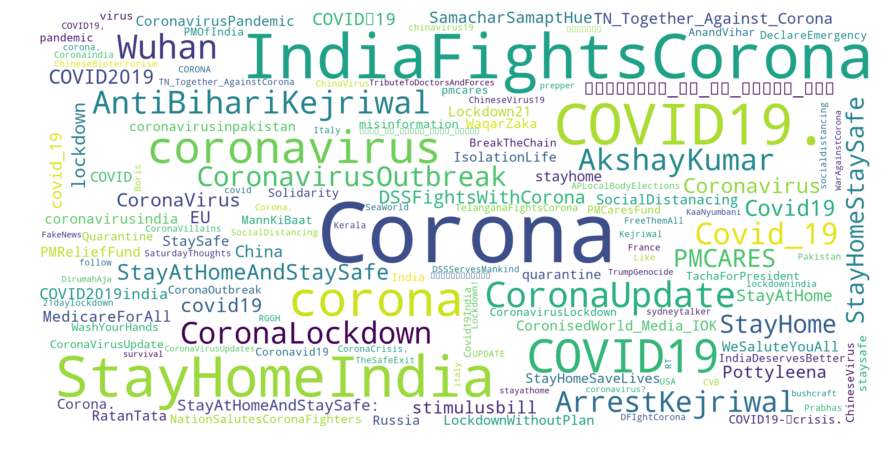

In [269]:
# tags cloud (with retweets)
# https://www.datacamp.com/community/tutorials/wordcloud-python
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=20, max_words=1000, background_color="white").generate_from_frequencies(hashtags_total_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [270]:
hashtags_total_dict.most_common(30)

[('Corona', 55421),
 ('IndiaFightsCorona', 26656),
 ('COVID19.', 22340),
 ('StayHomeIndia', 21878),
 ('corona', 15603),
 ('COVID19', 13932),
 ('coronavirus', 12970),
 ('CoronaUpdate', 7480),
 ('Wuhan', 6798),
 ('AntiBihariKejriwal', 5948),
 ('CoronaLockdown', 5514),
 ('AkshayKumar', 5399),
 ('Covid_19', 5371),
 ('ArrestKejriwal', 5063),
 ('CoronavirusOutbreak', 4466),
 ('PMCARES', 3690),
 ('StayHome', 3643),
 ('StayHomeStaySafe', 3445),
 ('Covid19', 2788),
 ('StayAtHomeAndStaySafe', 2690),
 ('Coronavirus', 2613),
 ('COVID2019', 2349),
 ('covid19', 2263),
 ('CoronaVirus', 2208),
 ('DSSFightsWithCorona', 2114),
 ('lockdown', 2056),
 ('EU', 1821),
 ('Pottyleena', 1782),
 ('stimulusbill', 1778),
 ('संस्कृति_की_ओर_बढ़ते_कदम', 1740)]

# Word Cloud

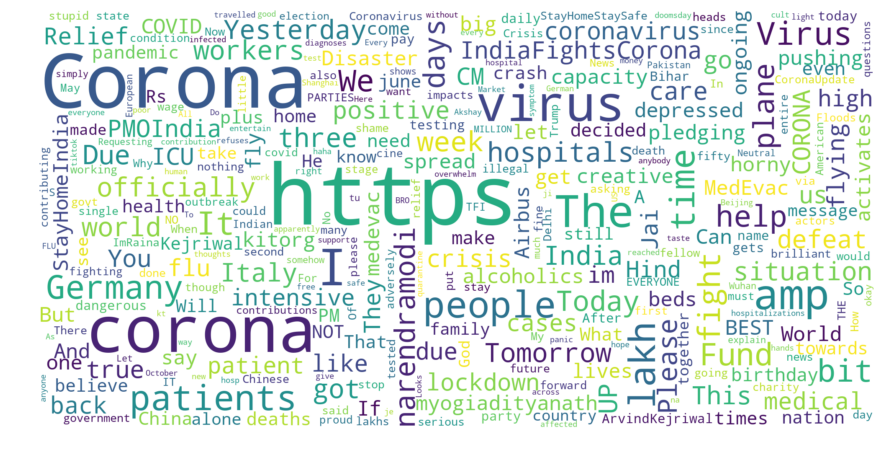

In [271]:
# vocabulary word cloud 1-gram
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=18, max_words=2000, background_color="white").generate_from_frequencies(words_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [272]:
words_dict.most_common(30)

[('https', 403547),
 ('Corona', 319521),
 ('corona', 225390),
 ('I', 132670),
 ('virus', 126014),
 ('The', 99427),
 ('amp', 89748),
 ('people', 67275),
 ('lakh', 65101),
 ('patients', 58718),
 ('time', 57354),
 ('Germany', 51320),
 ('It', 50151),
 ('Virus', 49363),
 ('Fund', 47176),
 ('bit', 46869),
 ('fight', 44661),
 ('We', 44439),
 ('help', 43065),
 ('days', 41969),
 ('plane', 40630),
 ('Today', 37752),
 ('narendramodi', 37569),
 ('week', 36605),
 ('hospitals', 35599),
 ('Due', 34636),
 ('officially', 33967),
 ('three', 33961),
 ('Yesterday', 33961),
 ('India', 33480)]

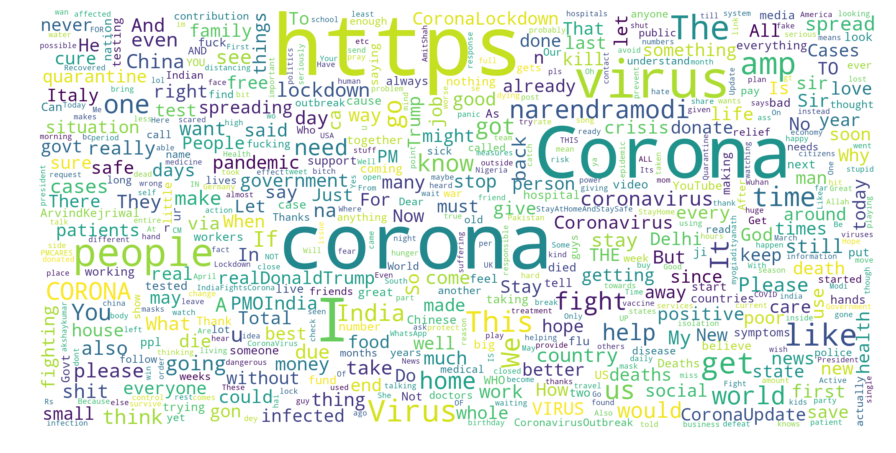

In [273]:
# vocabulary word cloud 1-gram
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=18, max_words=2000, background_color="white").generate_from_frequencies(words_orig_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [274]:
words_orig_dict.most_common(30)

[('https', 149049),
 ('corona', 125685),
 ('Corona', 107832),
 ('I', 75266),
 ('virus', 54407),
 ('people', 26304),
 ('The', 19152),
 ('amp', 16699),
 ('like', 15893),
 ('Virus', 15338),
 ('get', 15073),
 ('This', 14112),
 ('time', 12052),
 ('one', 11253),
 ('We', 11208),
 ('us', 11189),
 ('It', 11137),
 ('narendramodi', 10575),
 ('world', 10153),
 ('go', 10136),
 ('fight', 9920),
 ('CORONA', 9698),
 ('home', 9520),
 ('know', 9472),
 ('India', 9036),
 ('You', 8862),
 ('help', 8775),
 ('got', 8716),
 ('need', 8404),
 ('If', 7970)]

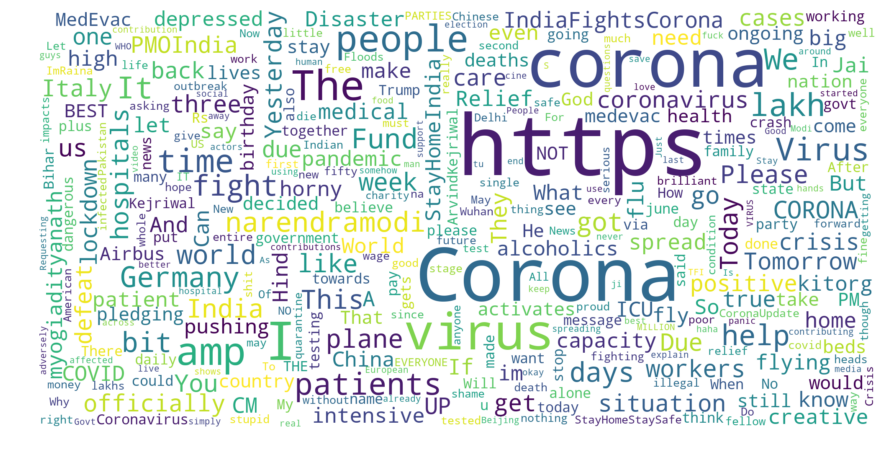

In [275]:
# vocabulary word cloud 1-gram
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=18, max_words=2000, background_color="white").generate_from_frequencies(words_total_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [276]:
words_total_dict.most_common(30)

[('https', 552596),
 ('Corona', 427353),
 ('corona', 351075),
 ('I', 207936),
 ('virus', 180421),
 ('The', 118579),
 ('amp', 106447),
 ('people', 93579),
 ('time', 69406),
 ('lakh', 65545),
 ('Virus', 64701),
 ('patients', 62099),
 ('It', 61288),
 ('We', 55647),
 ('fight', 54581),
 ('Germany', 52474),
 ('help', 51840),
 ('bit', 48441),
 ('narendramodi', 48144),
 ('Fund', 48103),
 ('days', 46576),
 ('This', 43380),
 ('world', 43336),
 ('India', 42516),
 ('got', 42131),
 ('plane', 40952),
 ('like', 39981),
 ('Please', 39297),
 ('Today', 38825),
 ('week', 38607)]

# 2-Gram Word Cloud

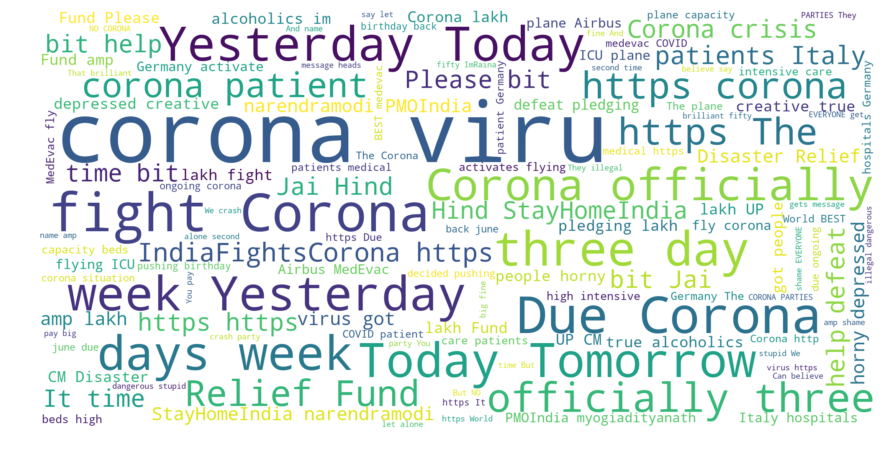

In [277]:
# vocabulary word cloud 2-gram 
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=18, max_words=2000, background_color="white").generate(' '.join(all_words))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [278]:
wordcloud.words_

{'corona viru': 1.0,
 'fight Corona': 0.25966523754922977,
 'Due Corona': 0.2429831995612942,
 'days week': 0.20791166060122637,
 'three day': 0.2077745650331522,
 'Yesterday Today': 0.20768109078219255,
 'Today Tomorrow': 0.20756892168104094,
 'week Yesterday': 0.20753153198065707,
 'Corona officially': 0.2074380577296974,
 'officially three': 0.207357046712199,
 'https corona': 0.1739181913355601,
 'https The': 0.17311431277730693,
 'Relief Fund': 0.16317488409192882,
 'corona patient': 0.15491176030709408,
 'IndiaFightsCorona https': 0.152300712896954,
 'patients Italy': 0.14411860012961764,
 'Corona crisis': 0.14059773667680342,
 'Jai Hind': 0.13787452016551174,
 'It time': 0.13725135849244727,
 'https https': 0.1366967446034199,
 'Please bit': 0.13553143227478937,
 'bit Jai': 0.13550027419113614,
 'help defeat': 0.1353943367067152,
 'bit help': 0.1353257889226781,
 'Hind StayHomeIndia': 0.13527593598883295,
 'time bit': 0.1352697043721023,
 'StayHomeIndia narendramodi': 0.13526970

In [279]:
# vocabulary word cloud 2-gram 
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=18, max_words=2000, background_color="white").generate(' '.join(all_words_orig))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [280]:
wordcloud.words_

{'corona viru': 1.0,
 'amp': 0.1393756802372352,
 'https http': 0.13592125810369576,
 'fight corona': 0.12918592362414624,
 'https Corona': 0.11601495338896162,
 'one': 0.07867880183604903,
 'It': 0.07356814991245643,
 'And': 0.07091818224837138,
 'virus https': 0.0693092733094626,
 'due corona': 0.06637538053851129,
 'us': 0.06509771755761314,
 'even': 0.06423016861996625,
 'stay home': 0.06296827925611621,
 'But': 0.06165906904112182,
 'people': 0.06027099074088679,
 'time': 0.05962427244191366,
 'know': 0.05689543669258798,
 'see': 0.056832342224395475,
 'still': 0.05303090051579728,
 'right': 0.05214757796110226,
 'That': 0.051642822215562253,
 'work': 0.05140621795984037,
 'gon na': 0.05113806647002224,
 'think': 0.05064908434153036,
 'get corona': 0.050349385617615976,
 'today': 0.050128554978942225,
 'https via': 0.049718440935690965,
 'So': 0.04962379923340221,
 'China': 0.04959225199930596,
 'What': 0.04888243923214032,
 'country': 0.04657949114311403,
 'https The': 0.04650062

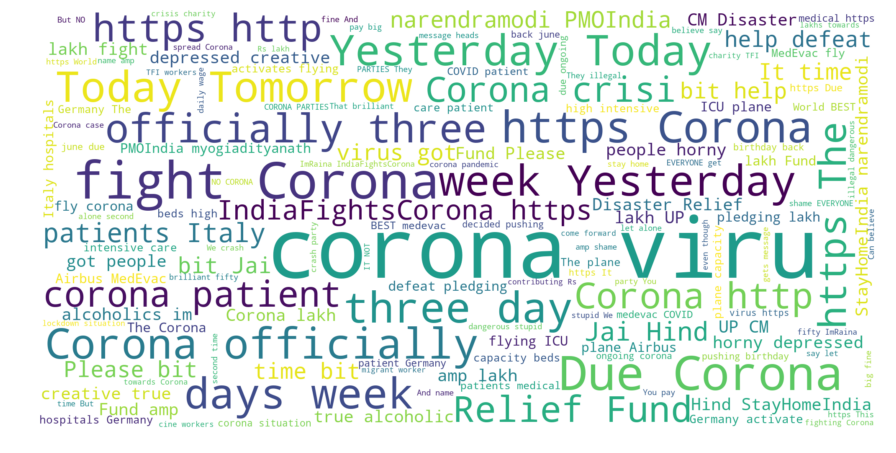

In [281]:
# vocabulary word cloud 2-gram 
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=18, max_words=2000, background_color="white").generate(' '.join(all_words_total))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [282]:
wordcloud.words_

{'corona viru': 1.0,
 'fight Corona': 0.22271506997395799,
 'Due Corona': 0.1929699958457848,
 'https Corona': 0.15752069290522583,
 'days week': 0.14956961437269117,
 'three day': 0.1495606805765872,
 'Yesterday Today': 0.14932393497983196,
 'Today Tomorrow': 0.14923013012074027,
 'week Yesterday': 0.14907825558697274,
 'Corona officially': 0.1490648548928168,
 'officially three': 0.14885491068437345,
 'https The': 0.1372588433414184,
 'https http': 0.1364771361823209,
 'Relief Fund': 0.12283969642960839,
 'Corona http': 0.12156663048479245,
 'corona patient': 0.12001661686075339,
 'Corona crisi': 0.11377636028212929,
 'IndiaFightsCorona https': 0.11188239550808732,
 'patients Italy': 0.103828578320357,
 'Jai Hind': 0.10123777745020525,
 'narendramodi PMOIndia': 0.10085809111578646,
 'It time': 0.0999066418307135,
 'Please bit': 0.09750345067874516,
 'bit help': 0.0974900499845892,
 'help defeat': 0.09747218239238126,
 'bit Jai': 0.09741411271770545,
 'time bit': 0.09735604304302962,


# Topic Modelling
using unique tweets in df table

In [283]:
def prepare_lda(t):
    tokens = []
    for word in word_tokenize(t):
        if word not in stopwordEn and word.isalpha():
            lemma = wordnet.morphy(word)
            if lemma is not None:
                tokens.append(lemma)
            else:
                tokens.append(word)
    return tokens
s_py = time.time()
text_data_orig = apply_by_multiprocessing(df_orig['text'], prepare_lda, workers=32)
print("programme:",time.time()-s_py)

programme: 23.262539625167847


In [284]:
s_py = time.time()
text_data_total = apply_by_multiprocessing(df_total['text'], prepare_lda, workers=32)
print("programme:",time.time()-s_py)

programme: 24.011626958847046


In [285]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = apply_by_multiprocessing(pd.Series(text_data), dictionary.doc2bow, workers=32)
# corpus = [dictionary.doc2bow(text) for text in text_data]

In [286]:
import gensim
NUM_TOPICS = 12
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
# ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=3)
for topic in topics:
    print(topic)

(0, '0.017*"ALL" + 0.016*"thanks" + 0.016*"hate"')
(1, '0.017*"doctor" + 0.016*"corona" + 0.016*"hospital"')
(2, '0.030*"God" + 0.028*"http" + 0.021*"cure"')
(3, '0.121*"http" + 0.088*"Corona" + 0.026*"Virus"')
(4, '0.046*"stay" + 0.033*"home" + 0.030*"safe"')
(5, '0.088*"I" + 0.081*"corona" + 0.051*"http"')
(6, '0.015*"bitch" + 0.014*"immune" + 0.014*"ImranKhanPTI"')
(7, '0.047*"http" + 0.042*"Corona" + 0.025*"virus"')
(8, '0.023*"http" + 0.014*"amp" + 0.013*"Corona"')
(9, '0.059*"http" + 0.027*"I" + 0.023*"corona"')
(10, '0.029*"http" + 0.009*"current" + 0.009*"cancel"')
(11, '0.066*"CORONA" + 0.029*"THE" + 0.026*"http"')


In [287]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [288]:
# total
from gensim import corpora
dictionary = corpora.Dictionary(text_data_total)
corpus = apply_by_multiprocessing(pd.Series(text_data_total), dictionary.doc2bow, workers=32)
# corpus = [dictionary.doc2bow(text) for text in text_data]

import gensim
NUM_TOPICS = 12
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
# ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=3)
for topic in topics:
    print(topic)

(0, '0.039*"http" + 0.035*"case" + 0.028*"Corona"')
(1, '0.181*"http" + 0.134*"Corona" + 0.065*"Virus"')
(2, '0.035*"http" + 0.022*"social" + 0.020*"distance"')
(3, '0.093*"I" + 0.076*"corona" + 0.028*"get"')
(4, '0.055*"http" + 0.046*"fight" + 0.035*"Corona"')
(5, '0.043*"http" + 0.026*"Corona" + 0.021*"fighting"')
(6, '0.045*"Corona" + 0.036*"virus" + 0.029*"corona"')
(7, '0.039*"corona" + 0.020*"people" + 0.016*"virus"')
(8, '0.079*"http" + 0.038*"Corona" + 0.037*"corona"')
(9, '0.069*"CORONA" + 0.048*"http" + 0.029*"via"')
(10, '0.030*"PMOIndia" + 0.021*"narendramodi" + 0.019*"India"')
(11, '0.049*"stay" + 0.048*"home" + 0.046*"http"')


In [289]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

# Get Overlap words

In [35]:
with open('032829_tweets_wordcloud_words.pickle','rb') as handle:
    dict_news = pickle.load(handle)

In [42]:
with open('032829_wordcloud_words_2gram.pickle','rb') as handle:
    dict_news_2g = pickle.load(handle)

In [55]:
dict_tweets2g = wordcloud.words_

In [73]:
dict_news_2g

{'New York': 1.0,
 'coronavirus pandemic': 0.5581711390072556,
 'social distancing': 0.5246573764827824,
 'public health': 0.4562248070943222,
 'tested positive': 0.43593228146953816,
 'confirmed case': 0.38555798687089715,
 'Prime Minister': 0.3676148796498906,
 'stay home': 0.36012898767707013,
 'coronavirus outbreak': 0.35994471956696994,
 'United State': 0.3381550155476218,
 'health care': 0.33472302199700565,
 'last week': 0.25995623632385123,
 'coronavirus case': 0.2509270989289416,
 'Donald Trump': 0.24869284809397674,
 'well': 0.24212829667165725,
 'two week': 0.24044685016699296,
 'new coronavirus': 0.23904180582747897,
 'novel coronaviru': 0.2286997581481055,
 'social media': 0.22342508349648738,
 'spread coronaviru': 0.2222964413221237,
 'York City': 0.20896003685362202,
 'President Donald': 0.20525164113785557,
 'federal government': 0.19940112864217435,
 'Associated Press': 0.19596913509155822,
 'new case': 0.19041805827478983,
 'per cent': 0.18666359553149833,
 'New Jerse

In [71]:
dict_tweets2g

{'corona virus': 1.0,
 'Relief Fund': 0.20864873570623288,
 'Fund corona': 0.1536479304235787,
 'PM CARE': 0.1536479304235787,
 'Any idea': 0.15211789338057657,
 'PM Relief': 0.15203736511515542,
 'corona already': 0.15187630858431309,
 'Why need': 0.15187630858431309,
 'CARES Fund': 0.15179578031889193,
 'need separate': 0.1516347237880496,
 'Fund Any': 0.15131261072636495,
 'separate PM': 0.1512320824609438,
 'already PM': 0.1512320824609438,
 'idea guys': 0.1512320824609438,
 'first thing': 0.1277983572233854,
 'What first': 0.11885971976163634,
 'IMAGINE CORONA': 0.1067804799484619,
 'VIRUS START': 0.10653889515219842,
 'Did You': 0.10597519729425028,
 'STARTS KILLING': 0.10589466902882912,
 'KILLING ALPHABETICALLY': 0.10589466902882912,
 'You Call': 0.10581414076340796,
 'Call That': 0.1057336124979868,
 'That Your': 0.1057336124979868,
 'ALPHABETICALLY Did': 0.10565308423256563,
 'Your Name': 0.10565308423256563,
 'Name Again': 0.10565308423256563,
 'virus RT': 0.0914801095184409

In [58]:
dict_tweets = wordcloud.words_

In [43]:
len(dict_tweets),len(dict_news_2g)

(2000, 2000)

In [37]:
co_words = [i for i in dict_tweets.keys() for v in dict_news.keys() if i==v]
len(co_words)

977

In [69]:
co_words_2g = [i for i in dict_tweets2g.keys() for v in dict_news_2g.keys() if i==v]
len(co_words_2g)

79

In [87]:
df_cowords_2g = pd.DataFrame({'co_words':co_words_2g})
df_cowords_2g['tweets'] = [dict_tweets2g[i] for i in co_words_2g]
df_cowords_2g['news'] = [dict_news_2g[i] for i in co_words_2g]
df_cowords_2g

co_words    tweets      news
0      Relief Fund  0.208649  0.041483
1   Prime Minister  0.058544  0.367615
2       daily wage  0.056209  0.018358
3         hot spot  0.038090  0.055050
4           gon na  0.037043  0.027778
..             ...       ...       ...
74           light  0.002818  0.016584
75       come back  0.002818  0.036209
76    people still  0.002818  0.029736
77       wash hand  0.002818  0.064885
78          change  0.002657  0.074859

[79 rows x 3 columns]

In [88]:
df_cowords = pd.DataFrame({'co_words':co_words})
df_cowords['tweets'] = [dict_tweets[i] for i in co_words]
df_cowords['news'] = [dict_news[i] for i in co_words]
df_cowords

co_words    tweets      news
0     corona  1.000000  0.009117
1     Corona  0.877477  0.008586
2      virus  0.487130  0.241588
3          I  0.390347  0.539432
4         PM  0.312227  0.029791
..       ...       ...       ...
972    looks  0.001931  0.009562
973    stage  0.001931  0.009530
974   supply  0.001931  0.032812
975      CDC  0.001931  0.020499
976   member  0.001931  0.024612

[977 rows x 3 columns]

In [90]:
with open('032829_df_cowords.pickle','wb') as handle:
    pickle.dump(df_cowords, handle)
with open('032829_df_cowords_2g.pickle','wb') as handle:
    pickle.dump(df_cowords_2g, handle)